<a href="https://colab.research.google.com/github/sourabh-bhide/SyntheticHealthData/blob/main/Diabetes_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://biolib.com/shd2020/Diabetes-Machine-Learning-Data/

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
real_data = pd.read_csv('/content/gdrive/MyDrive/Diabetes-Machine-Learning-Data/data/real_data.csv')
synthetic_data = pd.read_csv('/content/gdrive/MyDrive/Diabetes-Machine-Learning-Data/data/synthetic_data.csv')

In [ ]:
#define function for classifying players based on points
def f(row):
    if row['readmitted'] == '<30':
        val = 1
    elif row['readmitted'] == '>30':
        val = 2
    else:
        val = 3
    return val

#create new column 'Good' using the function above
synthetic_data['readmitted_num'] = synthetic_data.apply(f, axis=1)
real_data['readmitted_num'] = real_data.apply(f, axis=1)

In [ ]:
synthetic_data['readmitted'].unique()

array(['<30', 'NO', '>30'], dtype=object)

In [ ]:
dataframe = synthetic_data.copy()
dataframe.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,_diag_1,_diag_2,_diag_3,readmitted_num
0,Caucasian,Female,[60-70),3,40,0,14,0,1,1,9,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,<30,Supplemental classification,Diseases of the skin and subcutaneous tissue,"Endocrine, nutritional, and metabolic diseases...",1
1,Caucasian,Male,[50-60),5,40,0,5,0,0,0,3,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Injury and poisoning,Diabetes mellitus,Diseases of the circulatory system,3
2,Caucasian,Female,[50-60),1,43,0,23,0,0,3,9,Norm,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,>30,Diseases of the circulatory system,Diseases of the skin and subcutaneous tissue,Injury and poisoning,2
3,Caucasian,Female,[70-80),1,41,5,14,0,12,3,9,None,Norm,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30,Diseases of the respiratory system,Diseases of the musculoskeletal system and con...,Diseases of the circulatory system,2
4,Caucasian,Female,[80-90),4,68,2,17,0,0,1,4,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,>30,Diseases of the circulatory system,Diseases of the respiratory system,Injury and poisoning,2


# Exploratory Data Analysis

In [ ]:
df = dataframe.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78441 entries, 0 to 78440
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      78441 non-null  object
 1   gender                    78441 non-null  object
 2   age                       78441 non-null  object
 3   time_in_hospital          78441 non-null  int64 
 4   num_lab_procedures        78441 non-null  int64 
 5   num_procedures            78441 non-null  int64 
 6   num_medications           78441 non-null  int64 
 7   number_outpatient         78441 non-null  int64 
 8   number_emergency          78441 non-null  int64 
 9   number_inpatient          78441 non-null  int64 
 10  number_diagnoses          78441 non-null  int64 
 11  max_glu_serum             78441 non-null  object
 12  A1Cresult                 78441 non-null  object
 13  metformin                 78441 non-null  object
 14  repaglinide           

In [ ]:
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted_num
count,78441.000000,78441.000000,78441.000000,78441.000000,78441.000000,78441.000000,78441.000000,78441.000000,78441.000000
mean,4.036868,43.542752,1.188218,16.675297,0.516363,0.279076,0.746612,7.596729,2.418302
std,3.078212,20.357788,1.657656,8.361752,2.035255,1.838764,1.526452,1.839722,0.685137
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,1.000000
25%,2.000000,32.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000,2.000000
50%,3.000000,45.000000,0.000000,16.000000,0.000000,0.000000,0.000000,9.000000,3.000000
75%,5.000000,57.000000,2.000000,21.000000,0.000000,0.000000,1.000000,9.000000,3.000000
max,14.000000,126.000000,6.000000,75.000000,42.000000,76.000000,21.000000,16.000000,3.000000


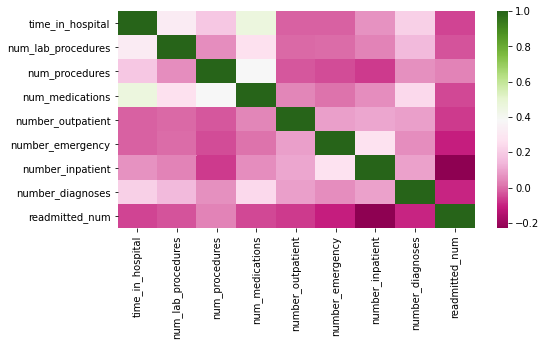

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
sns.heatmap(real_data.corr(),cmap='PiYG',annot=False)

# Split the dataframe into train, validation, and test

In [ ]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

50201 train examples
12551 validation examples
15689 test examples


# Using AutoML

In [ ]:
!pip install autokeras

In [ ]:
import autokeras as ak
from autokeras import StructuredDataClassifier


In [ ]:
train = train.drop(columns='readmitted')

x_train = train.drop(columns='readmitted_num')
y_train = train['readmitted_num']

input_node = ak.StructuredDataInput()
output_node = ak.StructuredDataBlock(categorical_encoding=True)(input_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, 
    outputs=output_node, 
    overwrite=True,
    max_trials=20)
clf.fit(x_train, y_train, epochs=50)

Trial 20 Complete [00h 01m 55s]
val_loss: 0.6795052886009216

Best val_loss So Far: 0.6533282399177551
Total elapsed time: 01h 02m 17s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
1569/1569 [==============================] - 6s 3ms/step - loss: 0.8809 - accuracy: 0.6073
Epoch 2/50
1569/1569 [==============================] - 4s 3ms/step - loss: 0.7663 - accuracy: 0.6747
Epoch 3/50
1569/1569 [==============================] - 4s 2ms/step - loss: 0.7409 - accuracy: 0.6848
Epoch 4/50
1569/1569 [==============================] - 4s 2ms/step - loss: 0.7254 - accuracy: 0.6911
Epoch 5/50
1569/1569 [==============================] - 4s 2ms/step - loss: 0.7146 - accuracy: 0.6942
Epoch 6/50
1569/1569 [==============================] - 5s 3ms/step - loss: 0.7060 - accuracy: 0.6993
Epoch 7/50
1569/1569 [==============================] - 4s 3ms/step - loss: 0.6997 - accuracy: 0.7011
Epoch 8/50
1569/1569 [==============================] - 4s 2ms/step - loss: 0.6939 - accuracy: 0.7024
Epoch 9/50


In [ ]:
test = test.drop(columns='readmitted')

x_test = test.drop(columns='readmitted_num')
y_test = test['readmitted_num']

predicted_y = clf.predict(x_test)
# Evaluate the best model with testing data.
print(clf.evaluate(x_test,y_test))

In [ ]:
model = clf.export_model()
model.summary()

In [ ]:
real_data = real_data.drop(columns='readmitted')
x_real_data = real_data.drop(columns='readmitted_num')
y_real_data = real_data['readmitted_num']
print(clf.evaluate(x_real_data,y_real_data))